# Rolling window features
Feature Engineering for Time Series Forecasting

In this notebook, we demonstrate how to compute rolling window features (also known as rolling window statistics) using Pandas, Feature-engine, and sktime.

## Data set synopsis
We will work with the hourly electricity demand dataset. It is the electricity demand for the state of Victora in Australia from 2002 to the start of 2015.

For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('talk')

## Load data

In [2]:
data = pd.read_csv('../datasets/victoria_electricity_demand.csv',
                  usecols=['demand', 'temperature', 'date_time'],
                  index_col=['date_time'],
                  parse_dates=['date_time'])

In [3]:
# for this demo we will use a subset of data
data = data.loc['2010':]

In [4]:
data.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,8314.448682,21.525
2010-01-01 01:00:00,8267.187296,22.400
2010-01-01 02:00:00,7394.528444,22.150
2010-01-01 03:00:00,6952.047520,21.800
2010-01-01 04:00:00,6867.199634,20.250


## Plot data

<Axes: xlabel='date_time'>

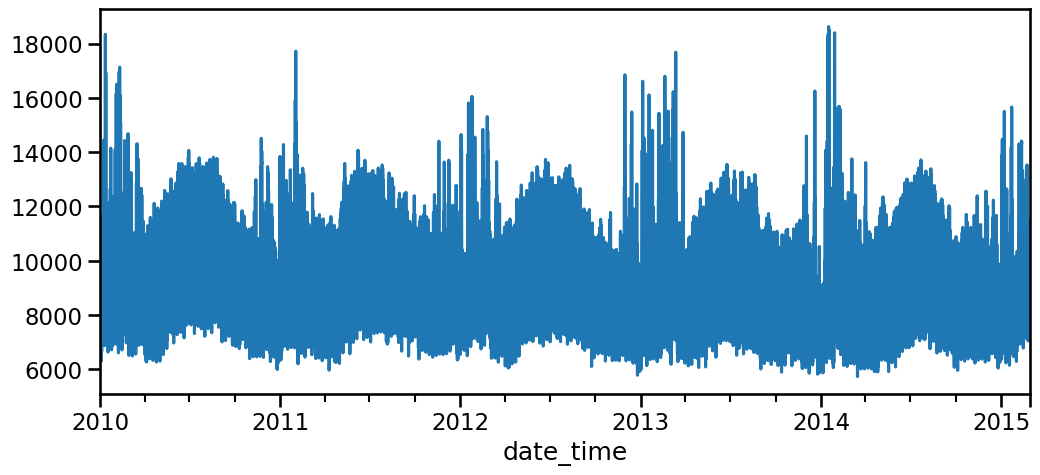

In [5]:
data['demand'].plot(figsize=[12, 5])

That's a lot of data. Let's look at smaller subset of data.

<Axes: xlabel='date_time'>

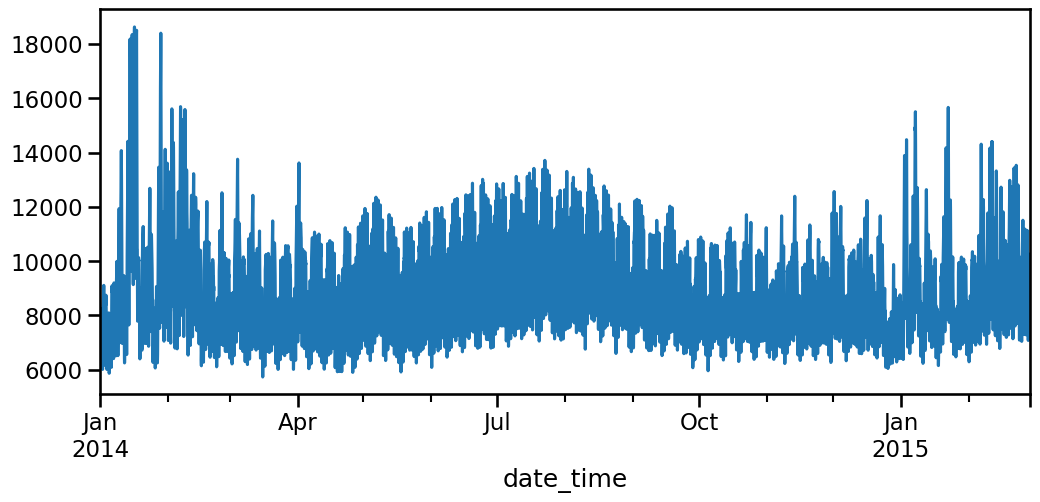

In [6]:
# plot the demand from year 2014 onwards
data['demand'].loc['2014':].plot(figsize=[12, 5])

<Axes: xlabel='date_time'>

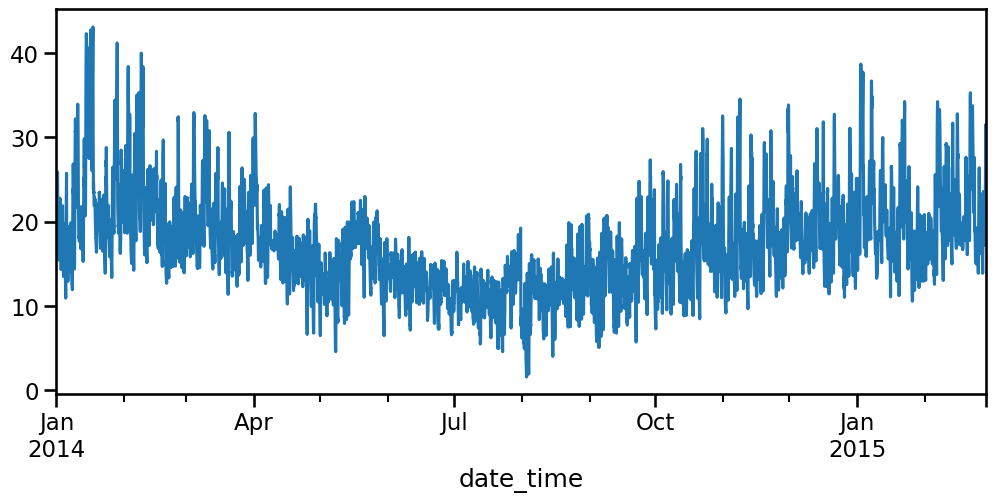

In [7]:
data['temperature'].loc['2014':].plot(figsize=[12, 5])

<Axes: xlabel='date_time'>

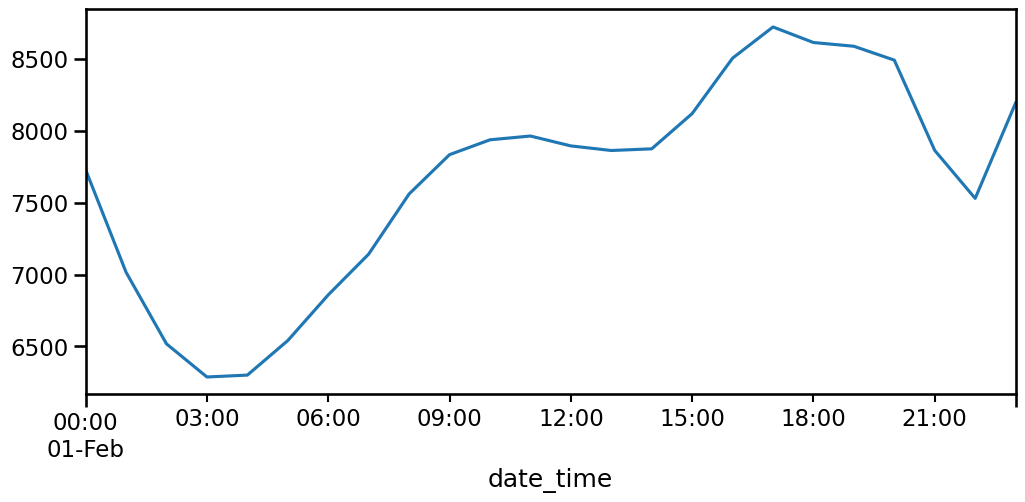

In [8]:
# demand on a single day
data['demand'].loc['2015-02-01'].plot(figsize=[12, 5])

<Axes: xlabel='date_time'>

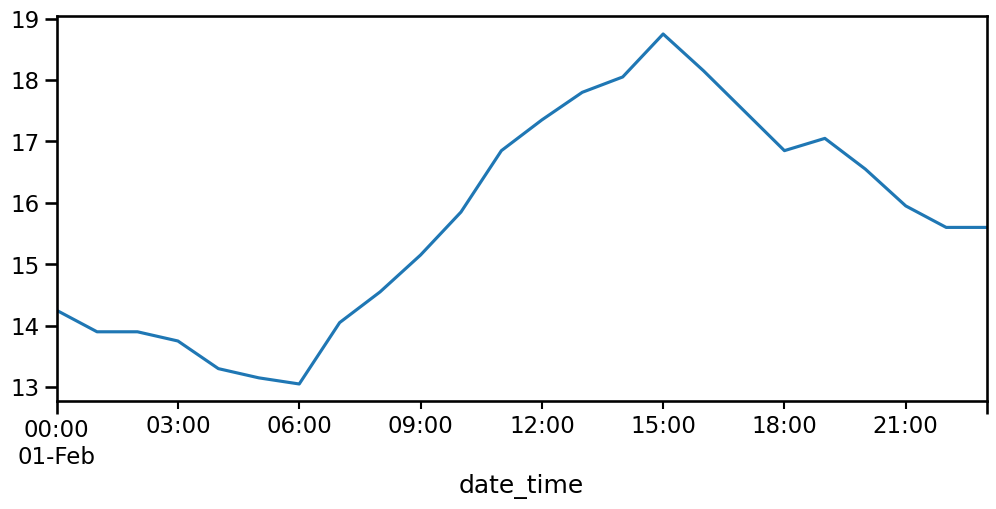

In [9]:
# temp on a single day
data['temperature'].loc['2015-02-01'].plot(figsize=[12, 5])

We can see that there is seasonality on different time scales (e.g. daily, weekly, yearly). We'll see how rolling window features can help capture info at these different time scales.

## Computing rolling windows features using Pandas

In [10]:
# create a copy of the data
df = data.copy()

We want to compute the rolling:
- mean
- standard deviation
- median absolute deviation

The median absolute deviation is not implemented natively in Pandas so we have to create it as a custom metric ourselves.

Let's create a function to compute the median absolute deviation which is defined as:
$$MAD = median(|x_i - median(x)|)$$

In [11]:
# create a custom metric for the MAD
def mad(x):
    return np.median(np.abs(x - np.median(x)))

We'll use a window size of 24 hours to smooth over daily seasonality. Let's compute the rolling window features

In [12]:
result = (df['demand'].rolling(window=24)         # pick window size
                     .agg(['mean', 'std', mad])   # pick statistics
                     .shift(freq='1H')            # lag by 1 hour to avoid data leakage
         )

result = result.add_prefix('demand_window_24_')

result

C:\Users\Asus\AppData\Local\Temp\ipykernel_2276\2146795739.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result = (df['demand'].rolling(window=24)         # pick window size


,demand_window_24_mean,demand_window_24_std,demand_window_24_mad
date_time,,,
2010-01-01 01:00:00,NaN,NaN,NaN
2010-01-01 02:00:00,NaN,NaN,NaN
2010-01-01 03:00:00,NaN,NaN,NaN
2010-01-01 04:00:00,NaN,NaN,NaN
2010-01-01 05:00:00,NaN,NaN,NaN
...,...,...,...
2015-02-28 20:00:00,8786.593557,957.615692,621.110944
2015-02-28 21:00:00,8764.566712,948.645664,655.453210
2015-02-28 22:00:00,8750.681279,952.771813,655.453210


Let's join this back to the original dataframe

In [13]:
df = df.join(result, how='left')

df

,demand,temperature,demand_window_24_mean,demand_window_24_std,demand_window_24_mad
date_time,,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN,NaN,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN,NaN,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN,NaN,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN,NaN,NaN
...,...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,8802.565712,974.759690,712.857278
2015-02-28 20:00:00,8883.230296,22.200,8786.593557,957.615692,621.110944
2015-02-28 21:00:00,8320.260550,18.900,8764.566712,948.645664,655.453210


The `min_periods` argument can be used to allow smaller window sizes to be applied at the start of the time series. This is one method to reduce the amount of missing data at the start of the time series. Alternatively, we can drop the missing data altogether.

In [14]:
result = (df['demand'].rolling(window=24, min_periods=1)
                    .agg(['mean', 'std', mad])
                     .shift(freq='1H'))

result = result.add_prefix('demand_window_24_min_periods_')

df = df.join(result, how='left')
df[['demand', 'demand_window_24_mean', 'demand_window_24_min_periods_mean']]

C:\Users\Asus\AppData\Local\Temp\ipykernel_2276\1439218418.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result = (df['demand'].rolling(window=24, min_periods=1)


,demand,demand_window_24_mean,demand_window_24_min_periods_mean
date_time,,,
2010-01-01 00:00:00,8314.448682,NaN,NaN
2010-01-01 01:00:00,8267.187296,NaN,8314.448682
2010-01-01 02:00:00,7394.528444,NaN,8290.817989
2010-01-01 03:00:00,6952.047520,NaN,7992.054807
2010-01-01 04:00:00,6867.199634,NaN,7732.052986
...,...,...,...
2015-02-28 19:00:00,9596.777060,8802.565712,8802.565712
2015-02-28 20:00:00,8883.230296,8786.593557,8786.593557
2015-02-28 21:00:00,8320.260550,8764.566712,8764.566712


## Using Feature engine

Let's see how we can extract window features using the Feature-engine library.

In [15]:
from feature_engine.timeseries.forecasting import WindowFeatures

In [16]:
# create a copy of the data
df = data.copy()

In [17]:
# create window features using the dataframe
transformer = WindowFeatures(variables=['demand', 'temperature'],
                            functions=['mean', 'std'],
                            window=[24, 24*7, 24*365],
                            freq='1H')

df = transformer.fit_transform(df)

df

C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\feature_engine\timeseries\forecasting\window_features.py:216: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X[self.variables_]
C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\feature_engine\timeseries\forecasting\window_features.py:216: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X[self.variables_]
C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\feature_engine\timeseries\forecasting\window_features.py:216: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X[self.variables_]


,demand,temperature,demand_window_24_mean,demand_window_24_std,temperature_window_24_mean,temperature_window_24_std,demand_window_168_mean,demand_window_168_std,temperature_window_168_mean,temperature_window_168_std,demand_window_8760_mean,demand_window_8760_std,temperature_window_8760_mean,temperature_window_8760_std
date_time,,,,,,,,,,,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,8802.565712,974.759690,21.856250,5.141695,9670.463454,1539.992921,21.085714,4.840353,9169.130177,1597.845042,16.279344,5.272056
2015-02-28 20:00:00,8883.230296,22.200,8786.593557,957.615692,22.216667,5.285145,9654.616819,1526.838185,21.069048,4.810218,9169.143383,1597.848099,16.280348,5.273518
2015-02-28 21:00:00,8320.260550,18.900,8764.566712,948.645664,22.360417,5.233421,9638.018555,1519.920008,21.031845,4.776845,9169.122487,1597.850641,16.280713,5.273817


Let's look at the rolling window mean of the demand.

Text(0.5, 0, 'Time')

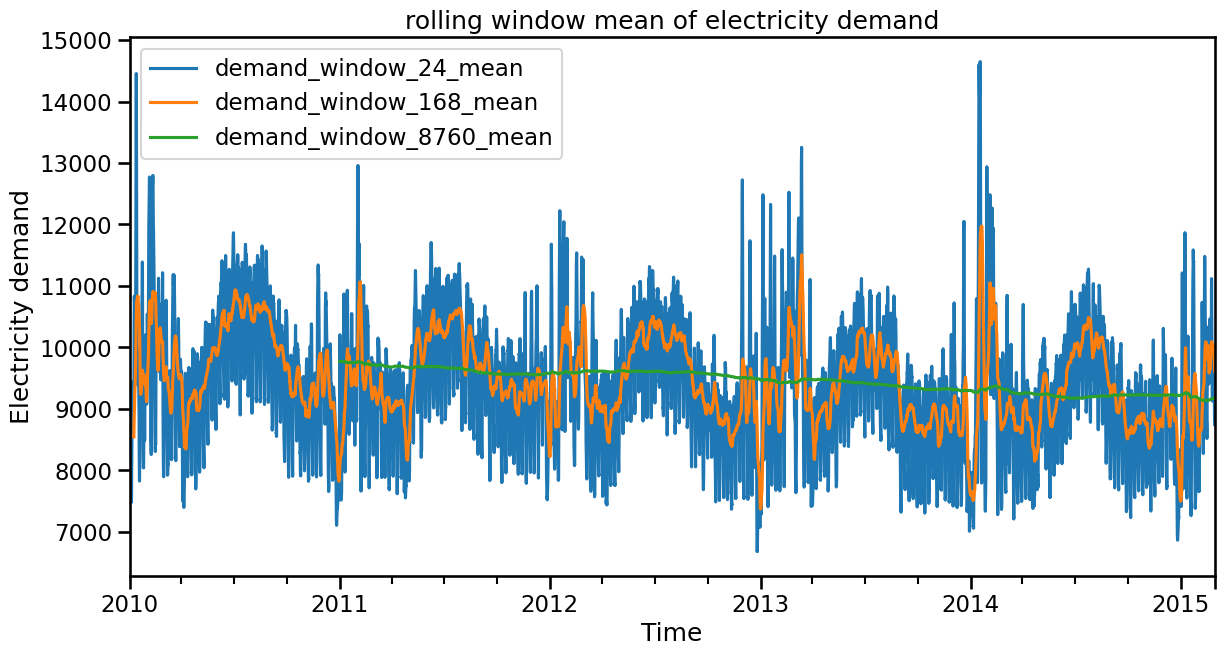

In [18]:
ax = df.filter(
    regex='demand_.*?_mean',
    axis=1
).plot(figsize=[14,7])

ax.set_title('rolling window mean of electricity demand')
ax.set_ylabel('Electricity demand')
ax.set_xlabel('Time')

We can see how different window sizes have smoothed over different seasonalities. This allows the model to make use of behaviors seen at different time scales (e.g., if the daily average of the demand is greater than the average of the past year then perhaps this can influence future values of our target variable).

## Using sktime

Let's see how we can extraact window features using sktime library.

In [19]:
from sktime.transformations.series.summarize import WindowSummarizer

In [20]:
df = data.copy()

In [21]:
transformer = WindowSummarizer(
    lag_feature={
        'lag': [1, 2, 3],                # create lag features
        'mean': [[1, 24], [1, 24*7]],    # [[lag, window size]]
        'std': [[1, 24], [1, 24*7]],
        mad: [[1, 12]]                   # can pass custom functions
    },
    target_cols=['demand']
)

result = transformer.fit_transform(df)
result

,demand_lag_1,demand_lag_2,demand_lag_3,demand_mean_1_24,demand_mean_1_168,demand_std_1_24,demand_std_1_168,demand_mad_1_12,temperature
date_time,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.525
2010-01-01 01:00:00,8314.448682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.400
2010-01-01 02:00:00,8267.187296,8314.448682,NaN,NaN,NaN,NaN,NaN,NaN,22.150
2010-01-01 03:00:00,7394.528444,8267.187296,8314.448682,NaN,NaN,NaN,NaN,NaN,21.800
2010-01-01 04:00:00,6952.047520,7394.528444,8267.187296,NaN,NaN,NaN,NaN,NaN,20.250
...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,9979.909902,10258.585392,10019.921572,8802.565712,9670.463454,974.759690,1539.992921,277.824899,28.350
2015-02-28 20:00:00,9596.777060,9979.909902,10258.585392,8786.593557,9654.616819,957.615692,1526.838185,223.694120,22.200
2015-02-28 21:00:00,8883.230296,9596.777060,9979.909902,8764.566712,9638.018555,948.645664,1519.920008,223.694120,18.900
